In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# Set the path to your dataset
dataset_path = 'C:/pythonn/breast_cancer_data/'

# Set the path to save the generated images
save_path = 'C:/pythonn/breast_cancer_data_generated_new/'

# Set the path to save the trained models
model_save_path = 'C:/pythonn/breast_cancer_models/'

# Load and preprocess the dataset
def load_dataset(dataset_path):
    images = []
    classes = ['BENIGN', 'MALIGNANT']
    image_shape = (28, 28) 

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            image = cv2.resize(image, image_shape)
            image = image.reshape((1,) + image_shape)
            image = image.astype(np.float32) / 255.0
            images.append(image)

    images = np.array(images)
    return images

# Load the breast cancer dataset
train_dataset = load_dataset(dataset_path)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 60

# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Initialize generator and discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Lists to store losses
G_losses = []
D_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        # Transfer data to device
        real_images = batch.to(device)

        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)

        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability to classify real and fake images
        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_images = generator(z)

        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)

        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()

        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Progress Monitoring
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} Generator Loss: {g_loss.item():.4f}"
            )

    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()

            # Save the generated images
            os.makedirs(save_path, exist_ok=True)
            for i, image in enumerate(generated):
                image = (image.squeeze().numpy() * 255).astype(np.uint8)
                image_path = os.path.join(save_path, f'generated_image_epoch{epoch + 1}_{i + 1}.png')
                cv2.imwrite(image_path, image)

            print(f'Saved generated images for epoch {epoch + 1}')

    # Save the models for generator and discriminator
    if (epoch + 1) % 10 == 0:
        generator_path = os.path.join(model_save_path, f'generator_epoch{epoch + 1}.pt')
        discriminator_path = os.path.join(model_save_path, f'discriminator_epoch{epoch + 1}.pt')
        torch.save(generator.state_dict(), generator_path)
        torch.save(discriminator.state_dict(), discriminator_path)
        print(f'Saved models for epoch {epoch + 1}')


Saved generated images for epoch 10
Saved models for epoch 10
Saved generated images for epoch 20
Saved models for epoch 20
Saved generated images for epoch 30
Saved models for epoch 30
Saved generated images for epoch 40
Saved models for epoch 40
Saved generated images for epoch 50
Saved models for epoch 50
Saved generated images for epoch 60
Saved models for epoch 60


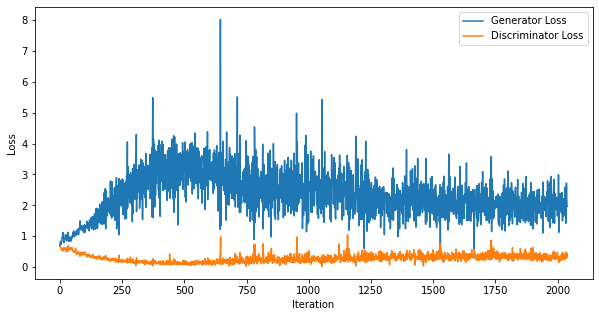

In [2]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
# Set the path to the folder containing generated images
generated_images_path = 'C:/pythonn/breast_cancer_data_generated_new/'

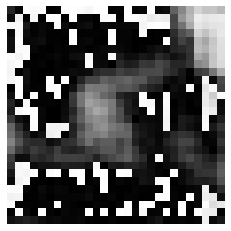

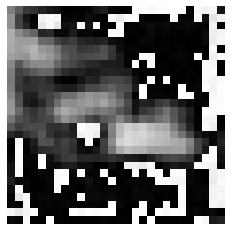

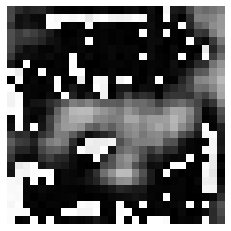

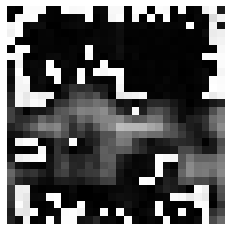

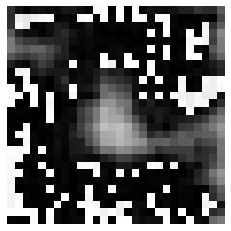

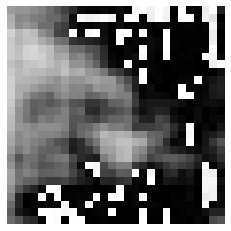

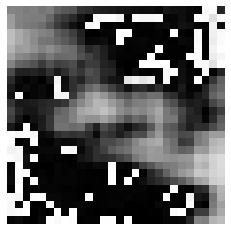

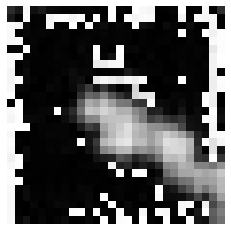

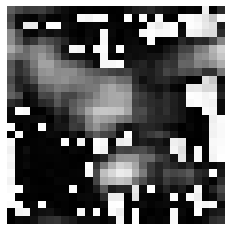

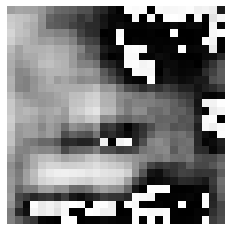

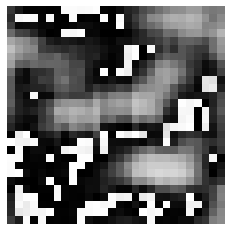

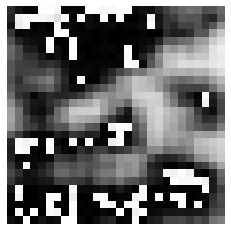

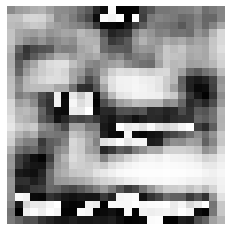

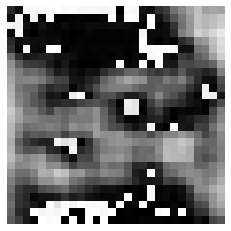

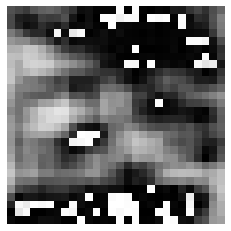

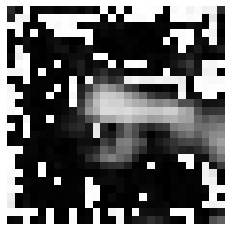

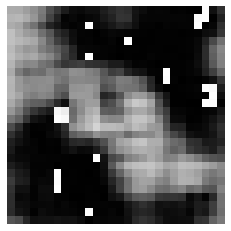

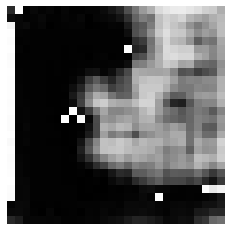

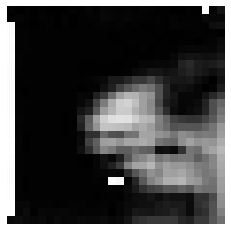

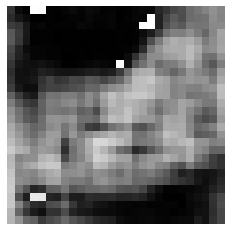

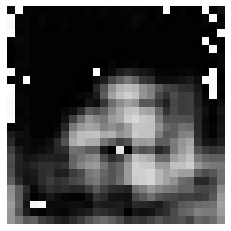

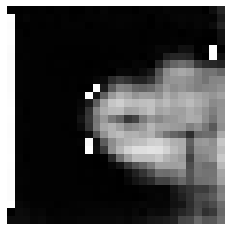

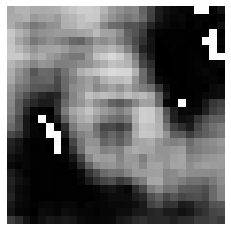

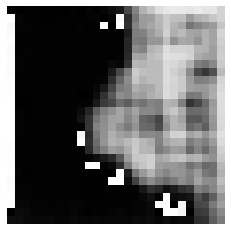

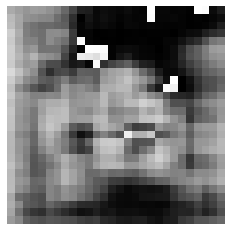

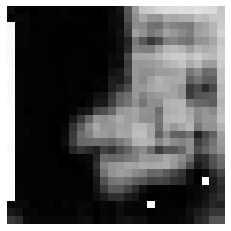

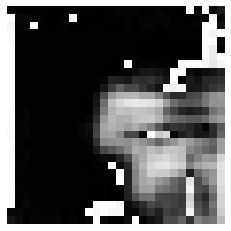

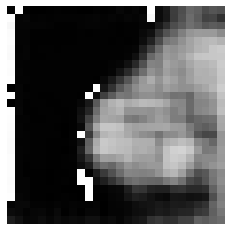

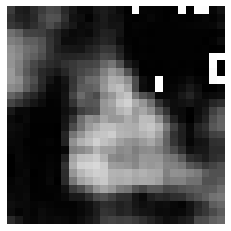

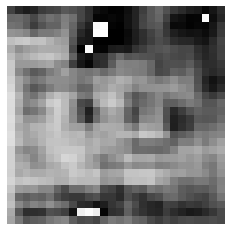

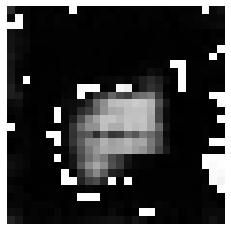

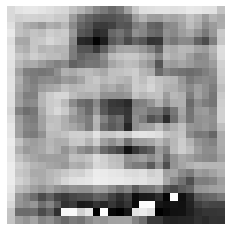

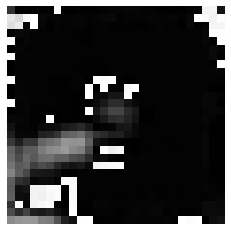

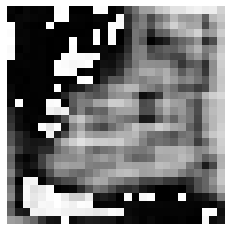

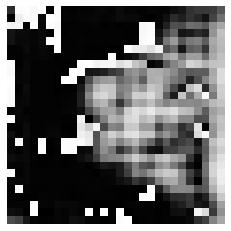

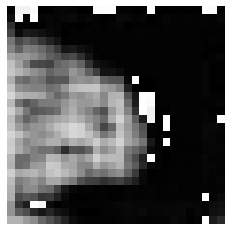

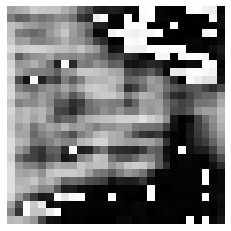

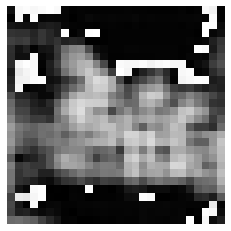

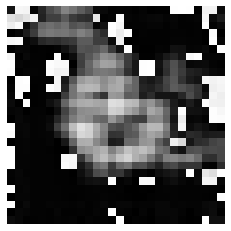

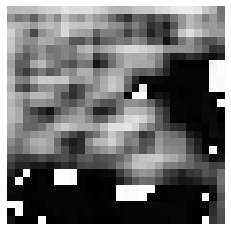

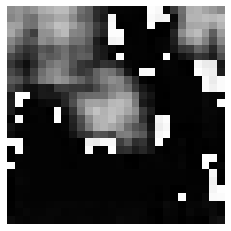

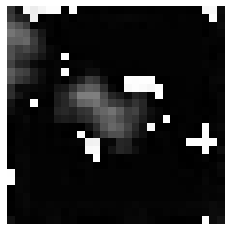

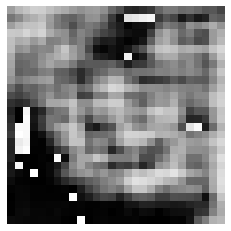

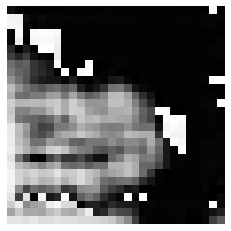

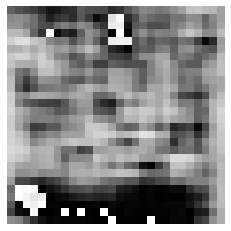

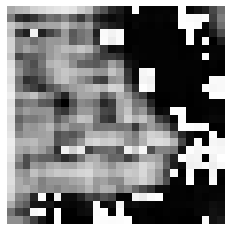

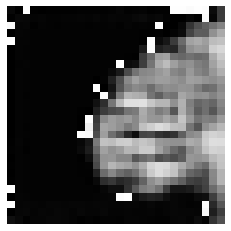

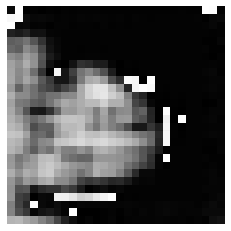

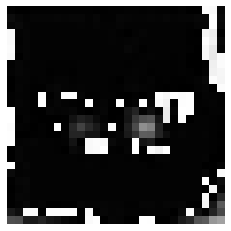

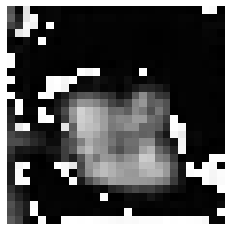

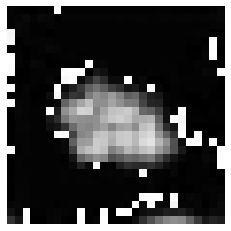

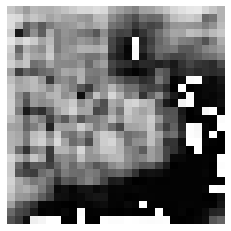

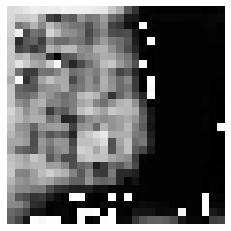

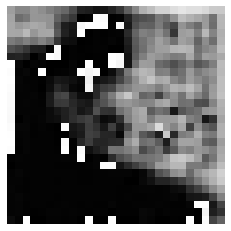

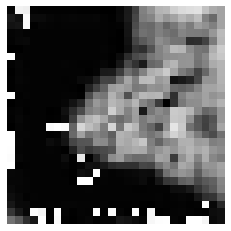

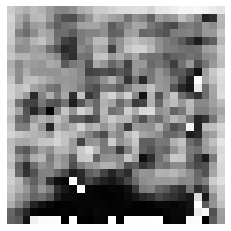

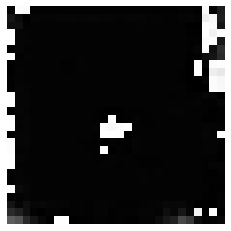

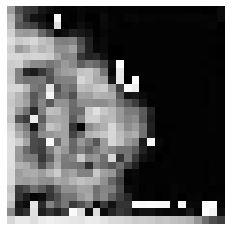

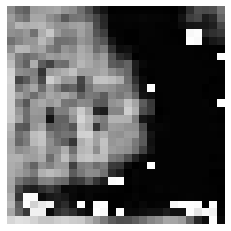

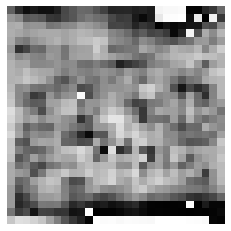

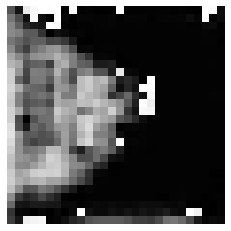

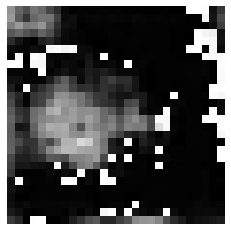

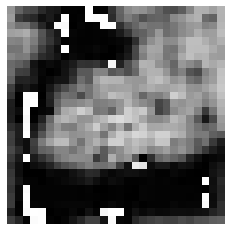

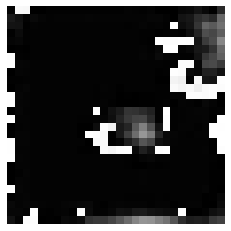

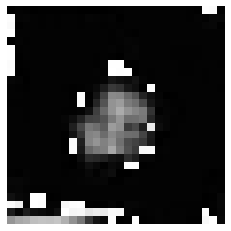

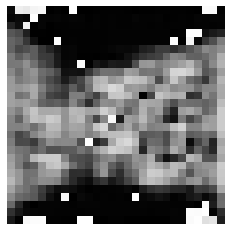

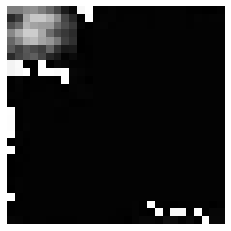

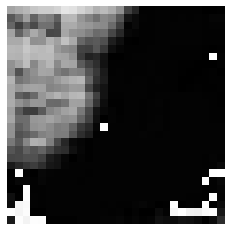

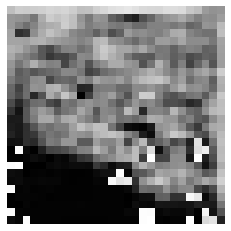

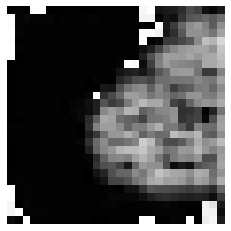

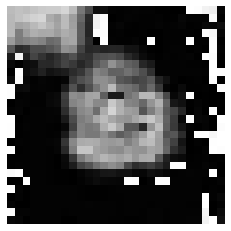

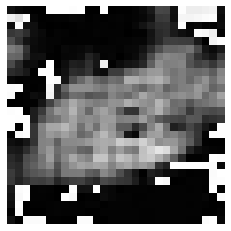

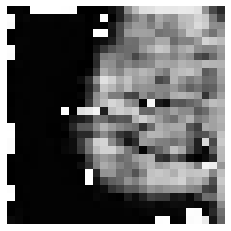

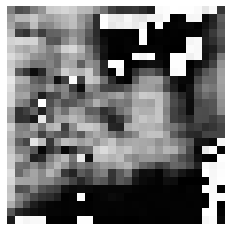

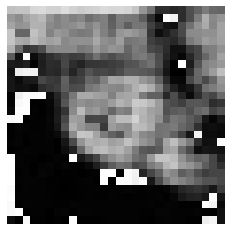

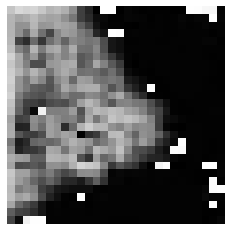

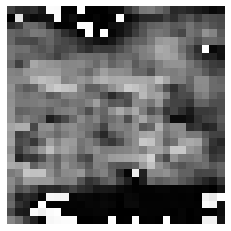

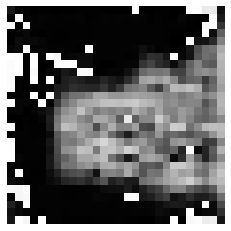

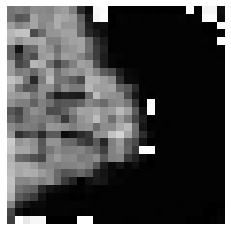

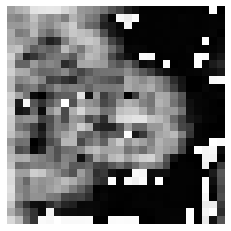

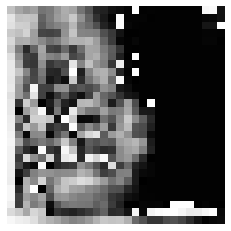

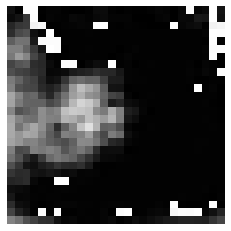

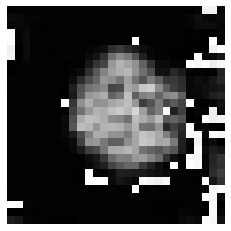

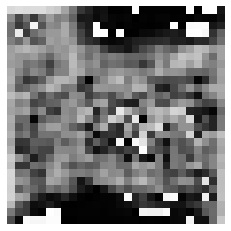

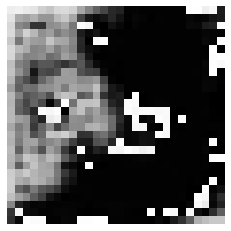

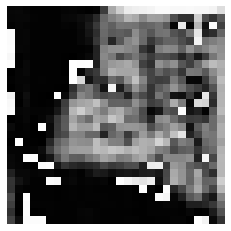

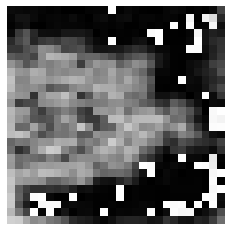

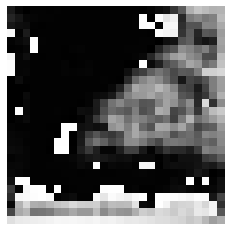

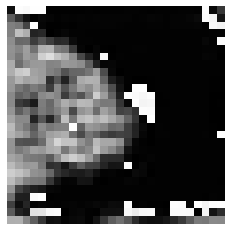

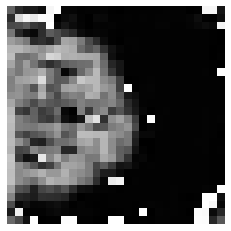

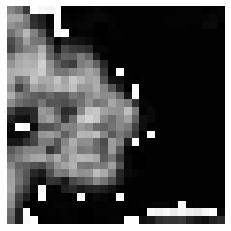

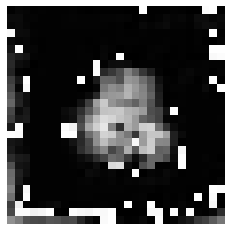

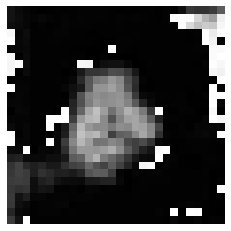

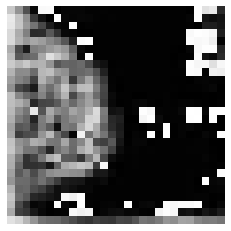

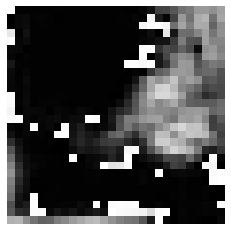

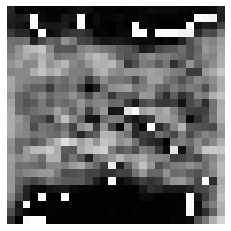

In [4]:
# Get the list of image file names in the folder
image_files = os.listdir(generated_images_path)

# Display the images
for image_file in image_files:
    image_path = os.path.join(generated_images_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis('off')
    plt.show()